<a href="https://colab.research.google.com/github/Kalkidan-Negaro/Image-Classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image Classification with CNNs

**Author:** Kalkidan Negaro  
**Date:** 17 November 2025  
**Framework:** TensorFlow / Keras  
**Purpose:** This notebook implements a Convolutional Neural Network (CNN) to classify CIFAR-10 images. It includes exploratory data analysis (EDA), preprocessing, model building, training, evaluation, and interpretation of results through feature maps and Grad-CAM visualisations.


### Section 1: Imports & Dataset Loading
- Import necessary libraries for data manipulation, visualisation, and deep learning.
- Set random seeds for reproducibility.
- Load the CIFAR-10 dataset and define class names.
- Display the shape of training and test sets.

In [ ]:
# Imports & Load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print("Train:", x_train.shape, "Test:", x_test.shape)
print("Labels shape:", y_train.shape, y_test.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train: (50000, 32, 32, 3) Test: (10000, 32, 32, 3)
Labels shape: (50000, 1) (10000, 1)


### Section 2: Exploratory Data Analysis (EDA)
- Show random training images to visualise the dataset.
- Examine the number of images per class using bar plots.
- Calculate pixel statistics (min, max, per-channel means and standard deviations) before normalisation.
- Plot pixel value distributions for each colour channel.
- Visualise mean and standard deviation images across the dataset.
- Display a few sample images per class to inspect class characteristics.
- Generate pairwise scatter plots of per-image channel means to observe relationships between RGB channels.

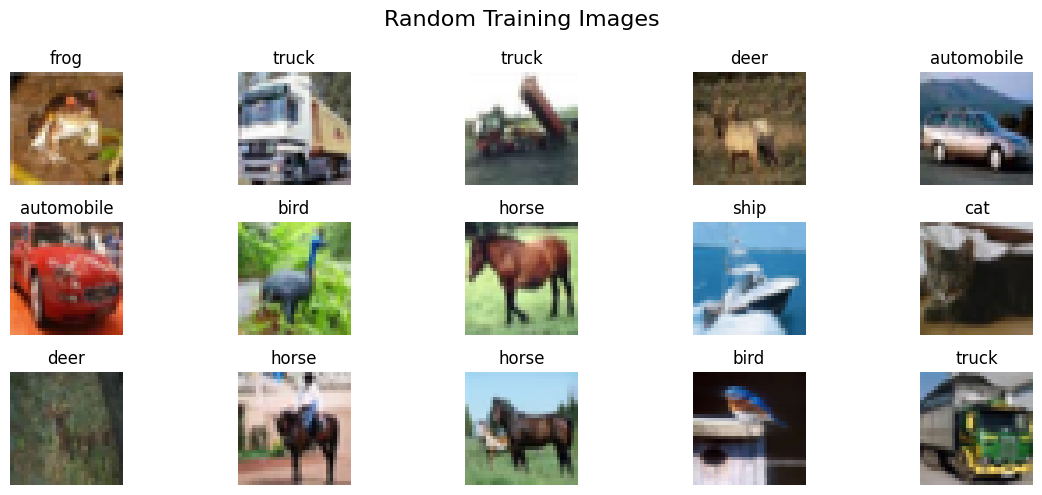

,Class,Count
0,airplane,5000
1,automobile,5000
2,bird,5000
3,cat,5000
4,deer,5000
5,dog,5000
6,frog,5000
7,horse,5000
8,ship,5000
9,truck,5000


/tmp/ipython-input-1993491376.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')


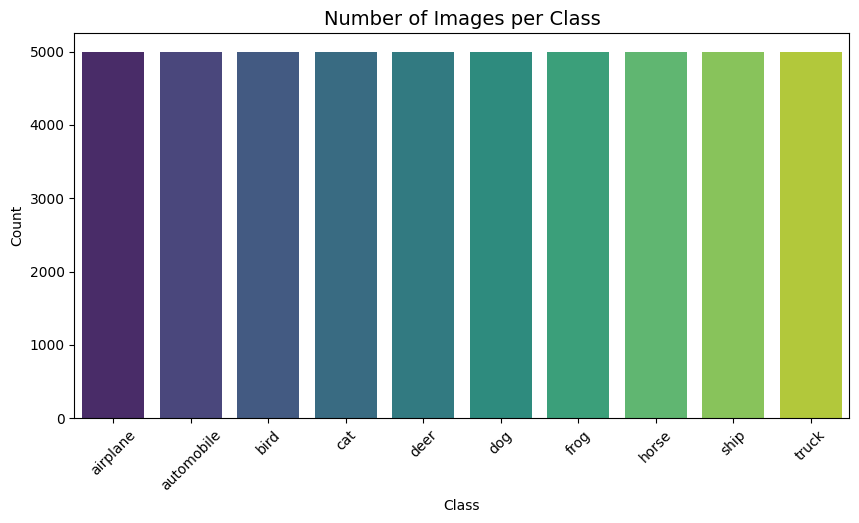

Pixel value range (train set): min = 0.0 , max = 1.0
Per-channel means (R,G,B): [0.4914009  0.48215896 0.4465308 ]
Per-channel stds (R,G,B): [0.24703279 0.24348423 0.26158753]


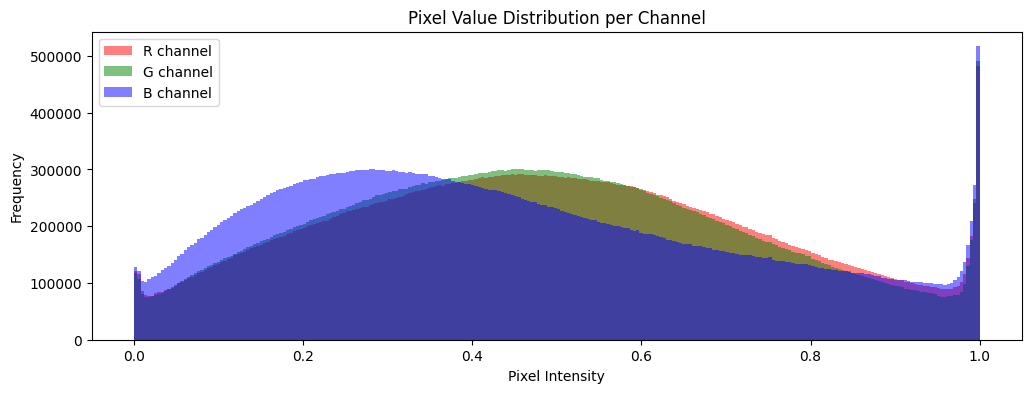

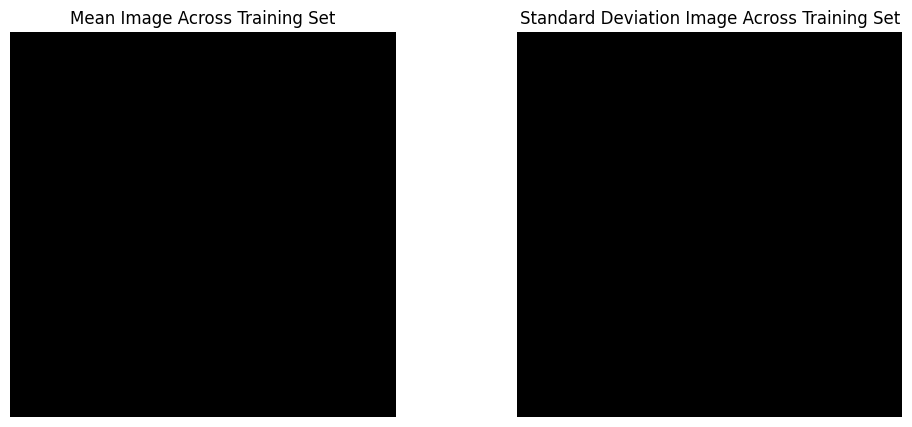

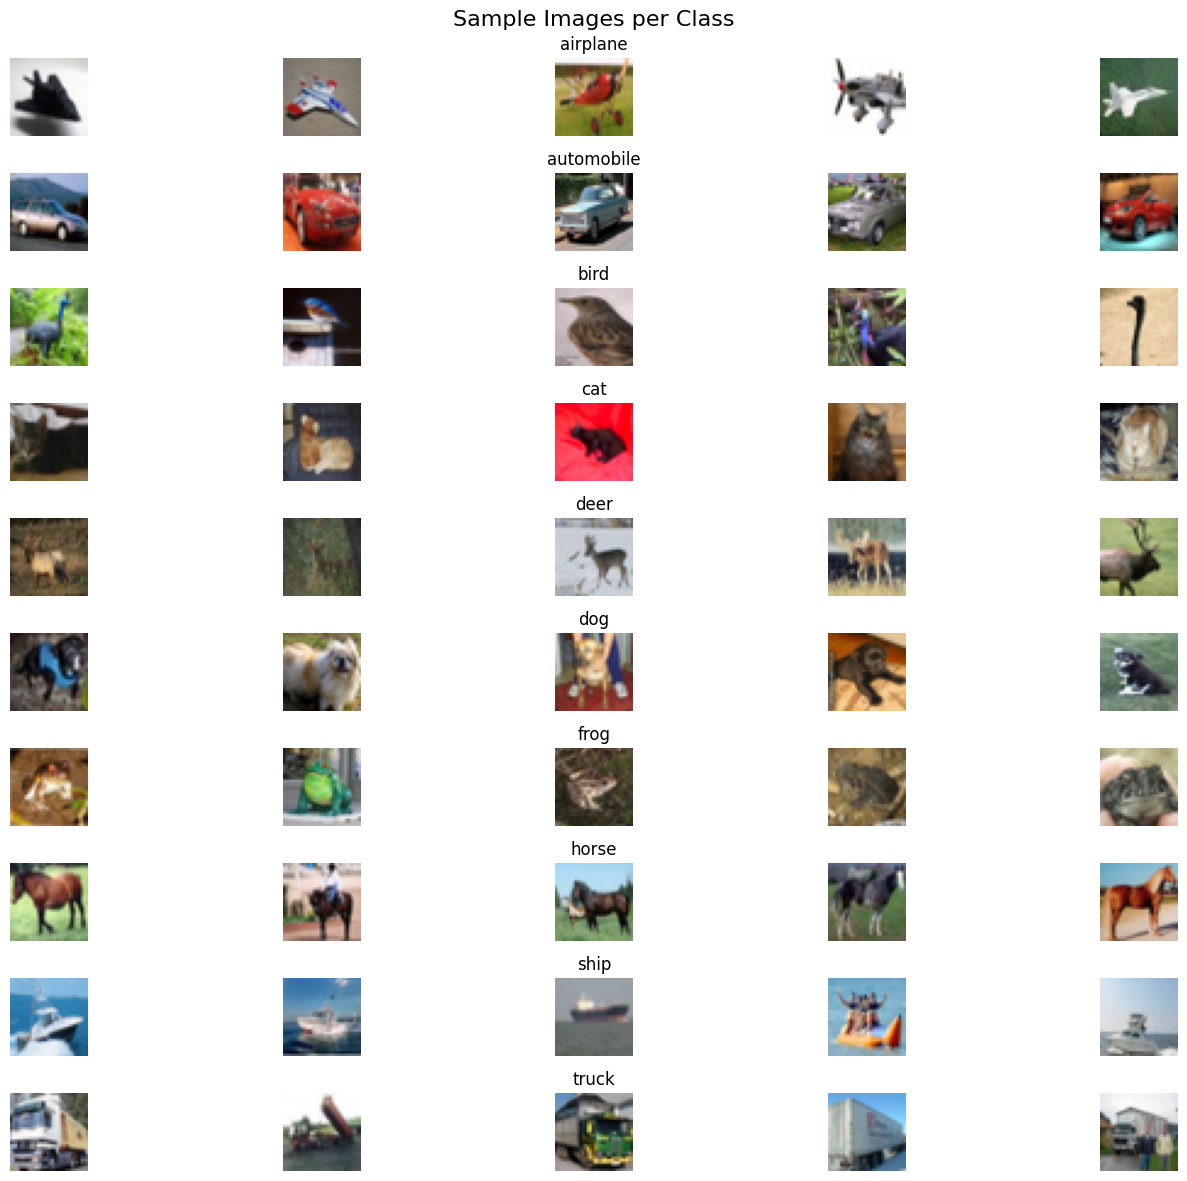

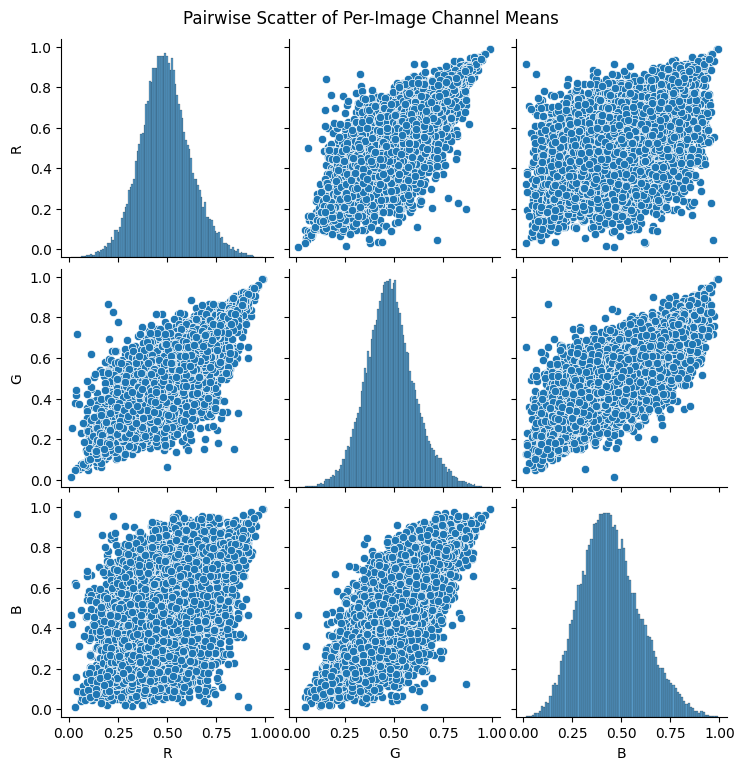

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 2.1: Display random training samples
plt.figure(figsize=(12,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.suptitle("Random Training Images", fontsize=16)
plt.tight_layout()
plt.show()

# 2.2: Class distribution
unique, counts = np.unique(y_train, return_counts=True)
df_counts = pd.DataFrame({"Class": class_names, "Count": counts})
display(df_counts)

plt.figure(figsize=(10,5))
sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')
plt.xticks(rotation=45)
plt.title("Number of Images per Class", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

# 2.3: Pixel statistics (before normalisation)
print("Pixel value range (train set): min =", x_train.min(), ", max =", x_train.max())

channel_means = x_train.mean(axis=(0,1,2))
channel_stds = x_train.std(axis=(0,1,2))
print("Per-channel means (R,G,B):", channel_means)
print("Per-channel stds (R,G,B):", channel_stds)

# 2.4: Pixel value histograms per channel
colors = ['r', 'g', 'b']
plt.figure(figsize=(12,4))
for i, color in enumerate(colors):
    plt.hist(x_train[:,:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
plt.title("Pixel Value Distribution per Channel")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 2.5: Mean and Std Heatmaps
mean_image = x_train.mean(axis=0)
std_image = x_train.std(axis=0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(mean_image.astype(np.uint8))
plt.title("Mean Image Across Training Set")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(std_image.astype(np.uint8))
plt.title("Standard Deviation Image Across Training Set")
plt.axis('off')
plt.show()

# 2.6: Sample images per class (5 per class)
plt.figure(figsize=(15,12))
for class_idx, class_name in enumerate(class_names):
    idxs = np.where(y_train[:,0] == class_idx)[0][:5]  # first 5 images for each class
    for i, img_idx in enumerate(idxs):
        plt.subplot(10,5,class_idx*5 + i + 1)
        plt.imshow(x_train[img_idx])
        if i == 2:
            plt.title(class_name)
        plt.axis('off')
plt.suptitle("Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.show()

# 2.7: Pairwise scatter of per-channel mean values
train_means_per_image = x_train.mean(axis=(1,2))  # shape (N,3)
df_means = pd.DataFrame(train_means_per_image, columns=['R','G','B'])
sns.pairplot(df_means)
plt.suptitle("Pairwise Scatter of Per-Image Channel Means", y=1.02)
plt.show()


### Section 3: Prototypes and Dimensionality Reduction
- Compute per-class prototype images by averaging all images in each class and visualise them.
- Select a subset of images for dimensionality reduction to save computation time.
- Apply PCA to reduce features to 50 dimensions before applying t-SNE.
- Use t-SNE to project the subset into 2D space for visualising class separability.
- Plot the 2D embeddings with different colours for each class to examine cluster structures.


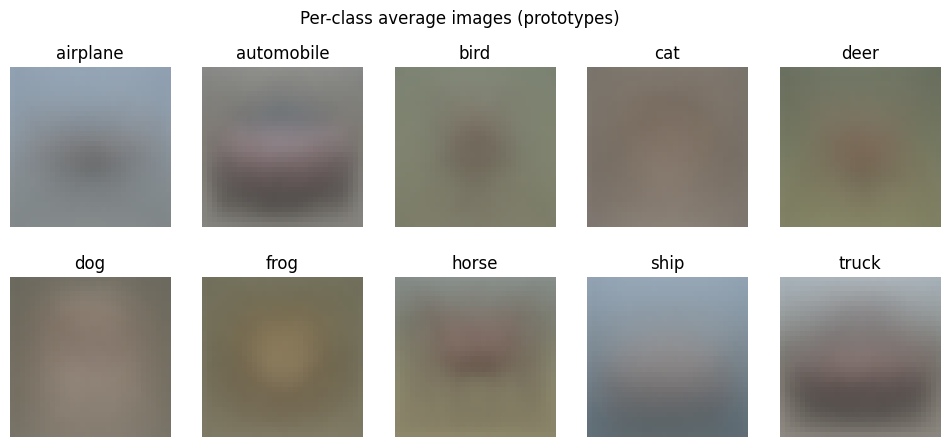

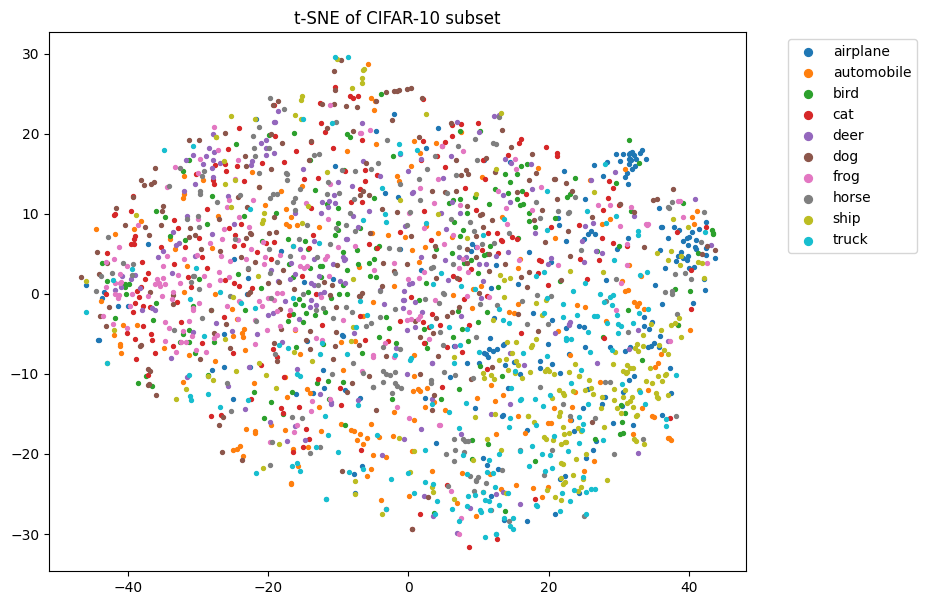

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Per-class prototype images (mean)
plt.figure(figsize=(12,5))
for i in range(10):
    mean_img = x_train[y_train.flatten()==i].mean(axis=0)
    plt.subplot(2,5,i+1)
    plt.imshow(mean_img.astype('uint8'))
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle("Per-class average images (prototypes)")
plt.show()

# t-SNE on subset (flattened)
subset = 2000
idx = np.random.choice(len(x_train), subset, replace=False)
X_sub = x_train[idx].reshape(subset, -1) / 255.0
y_sub = y_train[idx].flatten()
pca50 = PCA(n_components=50, random_state=42).fit_transform(X_sub)
tsne2 = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42).fit_transform(pca50)

plt.figure(figsize=(9,7))
for c in range(10):
    plt.scatter(tsne2[y_sub==c,0], tsne2[y_sub==c,1], s=8, label=class_names[c])
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1))
plt.title("t-SNE of CIFAR-10 subset")
plt.show()


### Section 4: Preprocessing and Data Augmentation
- Normalise image pixel values to the range [0,1] and convert labels to one-hot encoded vectors for multi-class classification.
- Implement data augmentation using random rotations, shifts, flips, and zooms to increase dataset variability and improve model generalisation.
- Fit the augmentation generator to the training data to enable on-the-fly augmentation during model training.


In [ ]:
# Normalise and one-hot encode
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

# Data augmentation generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)


### Section 5: CNN Model Building
- Construct a deep Convolutional Neural Network with three convolutional blocks, each followed by batch normalisation, ReLU activation, max-pooling, and dropout to reduce overfitting.
- Flatten the final feature maps and connect to a dense layer with L2 regularisation, followed by a dropout layer and the output layer with softmax activation for 10-class classification.
- Compile the model using the Adam optimiser and categorical cross-entropy loss, tracking accuracy as the performance metric.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

# Define a Sequential CNN model for CIFAR-10 classification
model = Sequential([
    # First Conv block
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    # Second Conv block
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.35),
    # Third Conv block
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.45),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 815,914 (3.11 MB)

 Trainable params: 815,018 (3.11 MB)

 Non-trainable params: 896 (3.50 KB)

### Section 6: Optimisation and Data Pipeline
- Check available physical devices and enable mixed precision to accelerate training using reduced-precision arithmetic while maintaining model performance.
- Construct efficient `tf.data` pipelines for training and test sets with shuffling, batching, and prefetching to improve input throughput and GPU utilisation.
- Set a batch size of 64, ensuring that the datasets are prepared for fast and scalable training.


In [ ]:

import tensorflow as tf

print("Devices:", tf.config.list_physical_devices())

# Enable Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled:", mixed_precision.global_policy())

# Build FAST tf.data pipelines
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = (
    train_ds
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Fast tf.data pipeline ready!")


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Mixed precision enabled: <DTypePolicy "mixed_float16">
Fast tf.data pipeline ready!


### Section 7: Model Training with Callbacks
- Compile the CNN model with the Adam optimiser and categorical cross-entropy loss, tracking accuracy during training.
- Implement callbacks for improved training: `EarlyStopping` to halt training when validation loss stops improving, and `ReduceLROnPlateau` to lower the learning rate when progress plateaus.
- Train the model using the augmented dataset from `ImageDataGenerator` for 40 epochs with a batch size of 64, validating on the test set and ensuring reproducibility with sequential data feeding.
- The process ensures efficient convergence while preventing overfitting and optimises learning rate dynamically.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Training Callbacks
callbacks = [
    EarlyStopping(
        patience=6,
        monitor='val_loss',
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        factor=0.2,
        patience=3,
        monitor='val_loss'
    )
]

# Train the model using ImageDataGenerator WITHOUT extra arguments
history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64, shuffle=True),
    epochs=40,
    validation_data=(x_test, y_test_cat),  # NO workers, NO multiprocessing
    callbacks=callbacks,
    verbose=2
)

print("Training Completed Successfully!")


Epoch 1/40
782/782 - 469s - 599ms/step - accuracy: 0.4852 - loss: 1.4332 - val_accuracy: 0.5734 - val_loss: 1.1984 - learning_rate: 1.0000e-03
Epoch 2/40
782/782 - 457s - 585ms/step - accuracy: 0.5623 - loss: 1.2569 - val_accuracy: 0.5422 - val_loss: 1.3922 - learning_rate: 1.0000e-03
Epoch 3/40
782/782 - 456s - 584ms/step - accuracy: 0.6087 - loss: 1.1423 - val_accuracy: 0.6360 - val_loss: 1.0595 - learning_rate: 1.0000e-03
Epoch 4/40
782/782 - 456s - 583ms/step - accuracy: 0.6379 - loss: 1.0703 - val_accuracy: 0.7024 - val_loss: 0.8875 - learning_rate: 1.0000e-03
Epoch 5/40
782/782 - 464s - 593ms/step - accuracy: 0.6589 - loss: 1.0141 - val_accuracy: 0.6480 - val_loss: 1.1449 - learning_rate: 1.0000e-03
Epoch 6/40
782/782 - 485s - 620ms/step - accuracy: 0.6749 - loss: 0.9757 - val_accuracy: 0.6971 - val_loss: 0.9114 - learning_rate: 1.0000e-03
Epoch 7/40
782/782 - 458s - 586ms/step - accuracy: 0.6933 - loss: 0.9324 - val_accuracy: 0.7049 - val_loss: 0.9463 - learning_rate: 1.0000e-03

### Section 8: Evaluation & Metrics
- Evaluate the trained CNN on the test set to obtain overall accuracy and loss, providing a quantitative measure of model performance.
- Plot training and validation accuracy and loss curves to visually inspect convergence, overfitting, or underfitting during training.
- Generate predictions on the test set, then compute a confusion matrix and classification report to assess per-class performance, highlighting where the model performs well or struggles.
- These metrics and visualisations help understand the strengths and weaknesses of the model and guide any further optimisation.


Test accuracy: 0.8040, Test loss: 0.6214


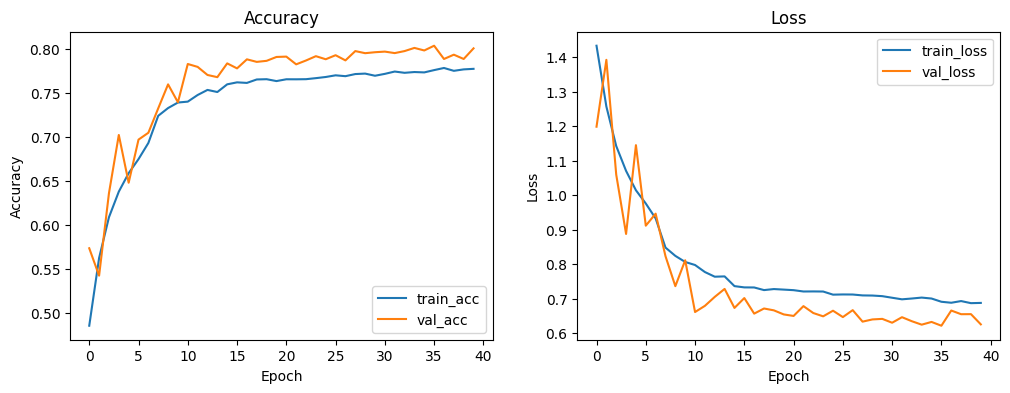

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step


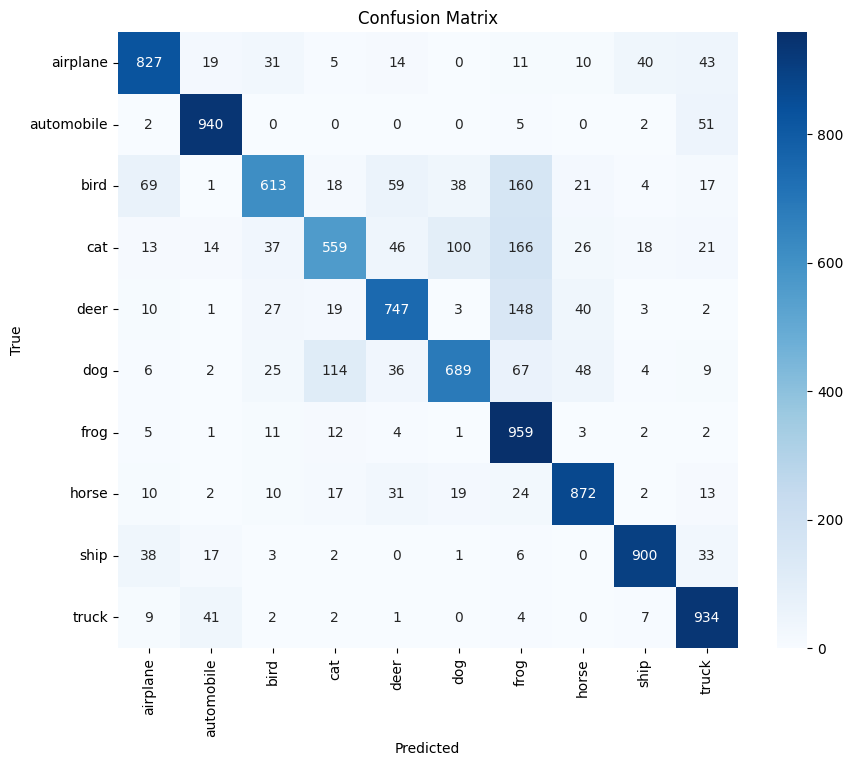

              precision    recall  f1-score   support

    airplane       0.84      0.83      0.83      1000
  automobile       0.91      0.94      0.92      1000
        bird       0.81      0.61      0.70      1000
         cat       0.75      0.56      0.64      1000
        deer       0.80      0.75      0.77      1000
         dog       0.81      0.69      0.74      1000
        frog       0.62      0.96      0.75      1000
       horse       0.85      0.87      0.86      1000
        ship       0.92      0.90      0.91      1000
       truck       0.83      0.93      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [13]:
import sklearn.metrics as skm
# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Accuracy & loss curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.show()

# Predictions -> confusion matrix and report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()

cm = skm.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

print(skm.classification_report(y_true, y_pred_classes, target_names=class_names))


### Section 9: Visualising Predictions
- Display a few correctly and incorrectly classified test images to visually inspect model performance.
- For each image, show the true label alongside the model's predicted label, helping identify patterns in misclassifications.
- This step provides an intuitive understanding of where the model succeeds and where it struggles, complementing numerical evaluation metrics.


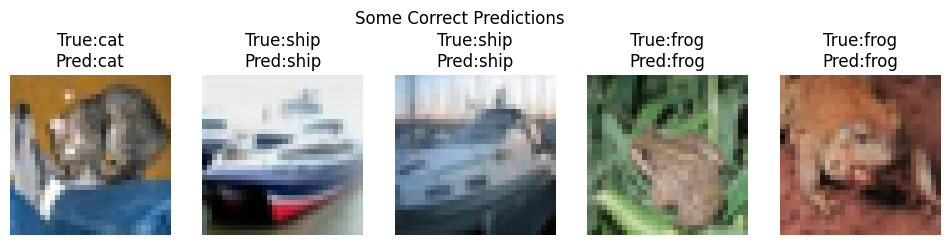

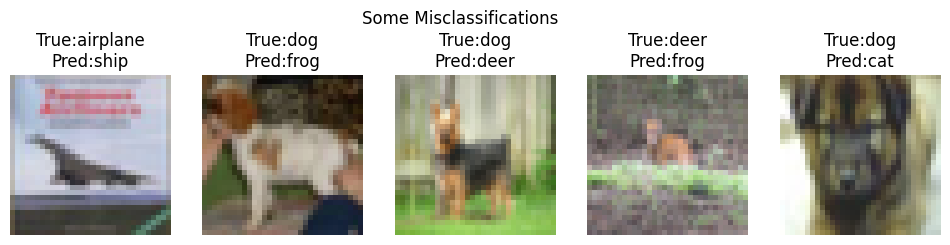

In [14]:
def show_examples(indices, title):
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(x_test[idx])
        plt.title(f"True:{class_names[y_true[idx]]}\nPred:{class_names[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.suptitle(title); plt.show()

# Get a few correct and incorrect examples
correct_idx = np.where(y_true == y_pred_classes)[0]
incorrect_idx = np.where(y_true != y_pred_classes)[0]
show_examples(correct_idx[:5], "Some Correct Predictions")
show_examples(incorrect_idx[:5], "Some Misclassifications")


### Section 10: Feature Map Visualisation
- Inspect the activations of the convolutional layers for a misclassified test image to understand what the model is focusing on.
- Extract outputs from all Conv2D layers and forward the sample image through the network.
- Visualise the first few feature maps of the initial convolutional layer to see the low-level features detected, such as edges and textures.
- This helps interpret the model’s internal processing and can provide insights into why certain misclassifications occur.


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


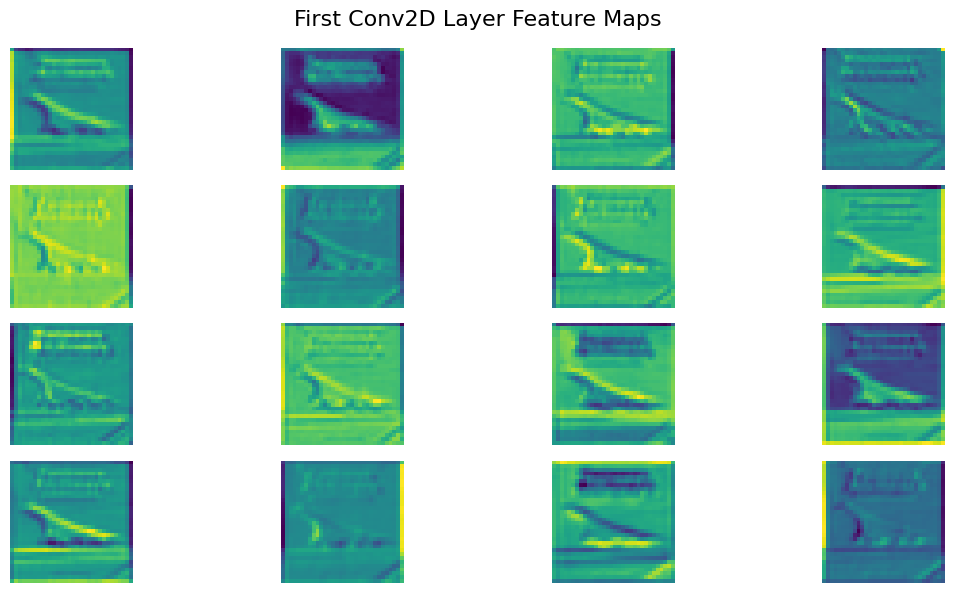

In [24]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Select a sample image
sample_idx = incorrect_idx[0] if len(incorrect_idx) > 0 else 0
sample_image = x_test[sample_idx].reshape(1, 32, 32, 3)

# Ensure the model is built / called
_ = model(sample_image)

# Get outputs of all Conv2D layers
conv_layers = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = Model(inputs=model.inputs, outputs=conv_layers)

# Forward pass through activation model
activations = activation_model(sample_image)

# Visualize first 16 feature maps of the first Conv2D layer
first_layer_activation = activations[0].numpy()
num_filters = min(first_layer_activation.shape[-1], 16)

plt.figure(figsize=(12,6))
for i in range(num_filters):
    plt.subplot(4,4,i+1)
    plt.imshow(first_layer_activation[0,:,:,i], cmap='viridis')
    plt.axis('off')
plt.suptitle("First Conv2D Layer Feature Maps", fontsize=16)
plt.tight_layout()
plt.show()


# References & Code Resources

1. **CIFAR‑10 Dataset** – Krizhevsky, A. (2009). *Learning multiple layers of features from tiny images*. Available: https://www.cs.toronto.edu/~kriz/cifar.html. Accessed: 21 November 2025.  
2. **TensorFlow & Keras Documentation** – TensorFlow Developers. *CIFAR10 dataset – Keras*. Available: https://keras.io/api/datasets/cifar10/. Accessed: 21 November 2025.  
3. **t‑SNE Implementation** – van der Maaten, L., & Hinton, G. (2008). *Visualising data using t‑SNE*. Journal of Machine Learning Research, 9, 2579–2605.  
4. **Grad‑CAM Methodology** – Selvaraju, R. R. et al. (2017). *Grad‑CAM: Visual explanations from deep networks via gradient‑based localisation*. Available: https://arxiv.org/abs/1610.02391. Accessed: 21 November 2025.  
5. **Data Augmentation in Keras** – Keras Documentation. *ImageDataGenerator API*. Available: https://keras.io/api/preprocessing/image/. Accessed: 21 November 2025.  
6. **Model Evaluation Techniques** – scikit‑learn. *Model evaluation: classification metrics*. Available: https://scikit-learn.org/stable/modules/model_evaluation.html. Accessed: 21 November 2025.  
